In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [18]:
# Datensatz laden und Überblick verschaffen
red_wines = pd.read_csv('./winequality-red.csv', delimiter = ';')
red_wines.head(5) 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [25]:
# Zeilen und Spalten Angabe des Datensatzes
print(f"Zeilen:",red_wines.shape[0])
print(f"Spalten:",red_wines.shape[1])

Zeilen: 1599
Spalten: 12


In [9]:
# Allgemeine Informationen über den Datensatz
red_wines.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


#### Es gibt keine fehlenden Werte im Datensatz!

In [39]:
# Welche Klassen gibt es für die Qualität
np.sort(red_wines['quality'].unique()) # eindeutige Werte aufsteigend sortiert

array([3, 4, 5, 6, 7, 8])

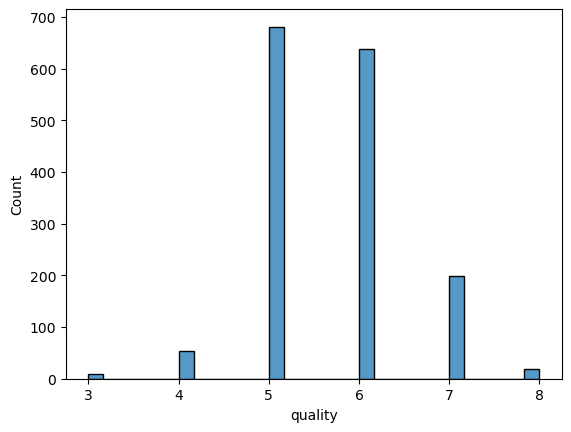

In [33]:
# Histogramm über die Verteilung der Qualitätsklassen
sns.histplot(red_wines['quality'])
plt.show()

#### Unbalancierte Verteilung der Daten
##### Qualitätskategorien 3 und 8 haben zu wenig Daten, wohingegen Kategorie 5 und 6 hoch repräsentiert sind.

In [43]:
# Die genaue Anzahl der Kategorien ausgeben lassen
red_wines['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [60]:
# Gibt es Duplikate und wenn ja wo liegen sie
# Anzahl der Duplikate in jeder Qualitätskategorie
red_wines['quality'].value_counts() - red_wines.drop_duplicates()['quality'].value_counts()

quality
5    104
6    103
7     32
4      0
8      1
3      0
Name: count, dtype: int64

#### Nachdem die Mehrheit der Duplikate in Kategorie 5 und 6 liegen, werden diese entfernt.
##### In den kleinen Kategoriegruppen 3,4 & 8 geht fast nichts verloren

In [63]:
# Qualitätskategorien mit Duplikaten
vals_per_class = red_wines['quality'].value_counts()

In [65]:
# Duplikate entfernen
red_wines.drop_duplicates(inplace = True)

In [67]:
# Qualitätskategorien ohne Duplikate in einer neuer Instanz speichern
new_vals_per_class = red_wines['quality'].value_counts()

new_vals_per_class

quality
5    577
6    535
7    167
4     53
8     17
3     10
Name: count, dtype: int64

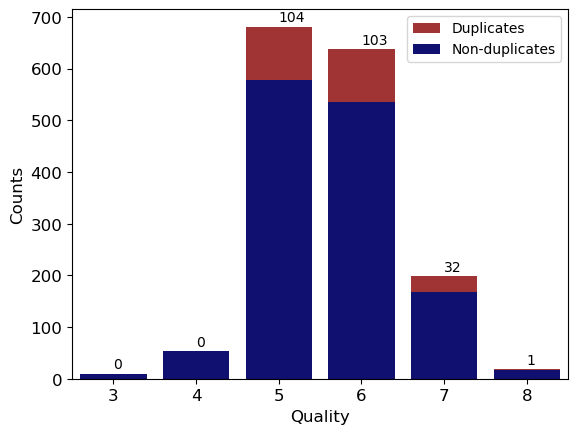

In [82]:
# Balkendiagramm erstellen
fig, ax = plt.subplots()
ax = sns.barplot(x=vals_per_class.index, y=vals_per_class.values, ax=ax, color='firebrick', label='Duplicates')
ax = sns.barplot(x=new_vals_per_class.index, y=new_vals_per_class.values, ax=ax, color='navy', label='Non-duplicates')

# Zahlenwerte über den Balken hinzufügen
for i in range(len(vals_per_class.index)):
    ax.text(vals_per_class.index[i] -3, # X-Koordinate
            vals_per_class.values[i]+10, # Y-Koordinate
            str(vals_per_class.values[i] - new_vals_per_class.values[i])) # Anzahl der entfernten Duplikate

# Legende und Achsenbeschriftungen
ax.legend(fontsize=10)
ax.tick_params(labelsize=12)
ax.set_xlabel('Quality', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
#fig.savefig('drop_duplicates.png', dpi=300)
plt.show()

In [20]:
# Anzahl der Gesamteinträge nach dem Entfernen der Duplikate
red_wines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


## Stratified Train/Test Split

In [88]:
# pandas data frame in numpy transformieren
X = red_wines.iloc[:, :-1].to_numpy()
y = red_wines.iloc[:, -1].to_numpy()
feature_names = red_wines.columns

In [105]:
# Liste aller Spalten
list(feature_names)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [107]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

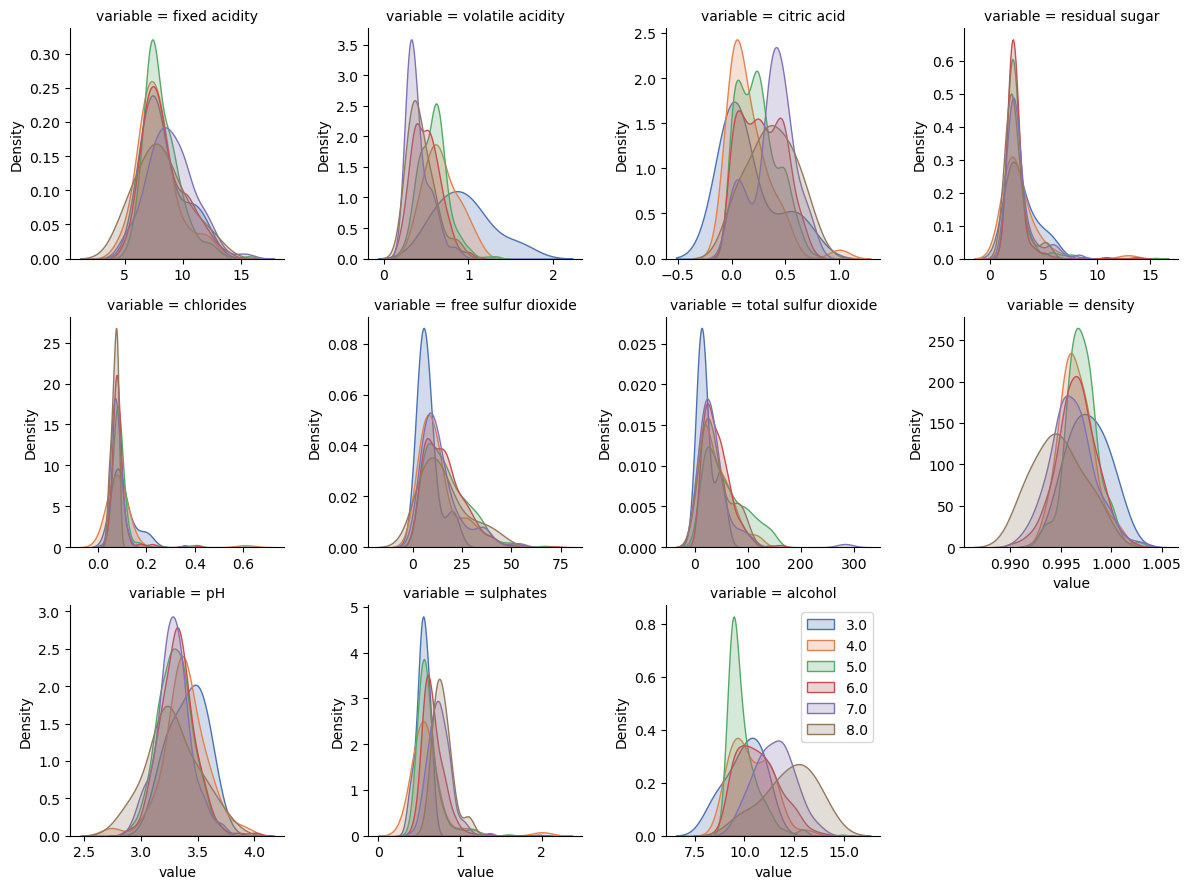

In [109]:
# Verteilungen der Diagonalen basierend auf den 6 verschiedenen Klassen 
red_wines_train = pd.DataFrame(np.hstack((X_train, y_train[:, None])), columns = feature_names)
df = pd.melt(red_wines_train, red_wines_train.columns[-1], red_wines_train.columns[:-1])

g = sns.FacetGrid(df, col="variable", hue="quality", col_wrap=4, sharex=False, sharey=False,  palette="deep")
g.map(sns.kdeplot, "value", label='quality', fill=True)
plt.legend()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,-0.25,0.69,0.11,0.11,-0.15,-0.11,0.68,-0.69,0.19,-0.08,0.12
volatile acidity,-0.25,1.00,-0.54,-0.02,0.04,-0.02,0.09,0.03,0.26,-0.27,-0.19,-0.40
citric acid,0.69,-0.54,1.00,0.16,0.22,-0.05,0.05,0.38,-0.58,0.32,0.09,0.24
residual sugar,0.11,-0.02,0.16,1.00,0.03,0.15,0.22,0.31,-0.10,-0.02,0.06,-0.01
chlorides,0.11,0.04,0.22,0.03,1.00,-0.01,0.03,0.21,-0.27,0.36,-0.22,-0.12
free sulfur dioxide,-0.15,-0.02,-0.05,0.15,-0.01,1.00,0.67,-0.04,0.05,0.05,-0.07,-0.03
total sulfur dioxide,-0.11,0.09,0.05,0.22,0.03,0.67,1.00,0.06,-0.08,0.01,-0.20,-0.17
density,0.68,0.03,0.38,0.31,0.21,-0.04,0.06,1.00,-0.37,0.14,-0.51,-0.18
pH,-0.69,0.26,-0.58,-0.10,-0.27,0.05,-0.08,-0.37,1.00,-0.20,0.23,-0.06
sulphates,0.19,-0.27,0.32,-0.02,0.36,0.05,0.01,0.14,-0.20,1.00,0.10,0.26


<Axes: >

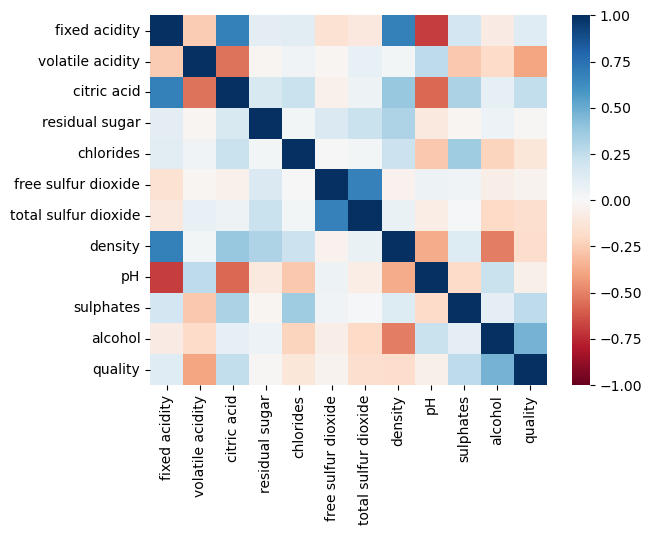

In [123]:
# Visualisierung der Korrelationsmatrix für die Trainingsdaten
display(red_wines_train.corr().round(2))
sns.heatmap(red_wines_train.corr(), vmin=-1, vmax=1, cmap='RdBu')

#### Aus der Korrelationsmatrix wird ersichtlich, dass die Spalten *volatile acidity, sulphates und alcohol* die höchste Korrelation mit der Zielspalte (quality) haben.
#### Diese Spalten wirken vermutlich am meisten auf das Ergebnis aus und werden deshalb genauer betrachtet.

In [121]:
# Deskriptive Statistik für die wichtigsten Spalten für die Trainingsdaten basierend auf der Korrelationsmatrix
red_wines_train[['volatile acidity', 'sulphates', 'alcohol', 'quality']].describe().round(2)

,volatile acidity,sulphates,alcohol,quality
count,1087.00,1087.00,1087.00,1087.00
mean,0.53,0.66,10.44,5.63
std,0.19,0.17,1.10,0.82
min,0.16,0.37,8.40,3.00
25%,0.39,0.55,9.50,5.00
50%,0.52,0.62,10.20,6.00
75%,0.64,0.72,11.20,6.00
max,1.58,2.00,14.90,8.00


,volatile acidity,sulphates,alcohol,quality
volatile acidity,1.00,-0.27,-0.19,-0.40
sulphates,-0.27,1.00,0.10,0.26
alcohol,-0.19,0.10,1.00,0.47
quality,-0.40,0.26,0.47,1.00


<Axes: >

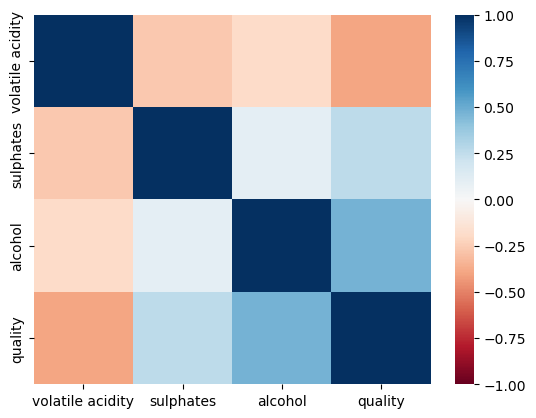

In [119]:
# Visualisierung der Korrelationsmatrix für die wichtigsten Spalten
display(red_wines_train[['volatile acidity', 'sulphates', 'alcohol', 'quality']].corr().round(2))
sns.heatmap(red_wines_train[['volatile acidity', 'sulphates', 'alcohol', 'quality']].corr(), vmin=-1, vmax=1, cmap='RdBu')

## Transform and Scale

In [138]:
# PowerTransformer um die Daten symmetrischer und normalverteilter zu machen
# Yeo-Johnson Methode für positive und negative Werte
pscaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

# QuantileTransformer ersetzt Werte durch entsprechende Quantile in einer Normalverteilung
# Aufteilung der Daten in 100 Quantile
qscaler = QuantileTransformer(n_quantiles=100, output_distribution='normal',ignore_implicit_zeros=False, subsample=100, random_state=42, copy=True)

# Jeweiligen Transformer auf die Spalten anwenden
X_train_pscl = pscaler.fit_transform(X_train)
X_train_qscl = qscaler.fit_transform(X_train)


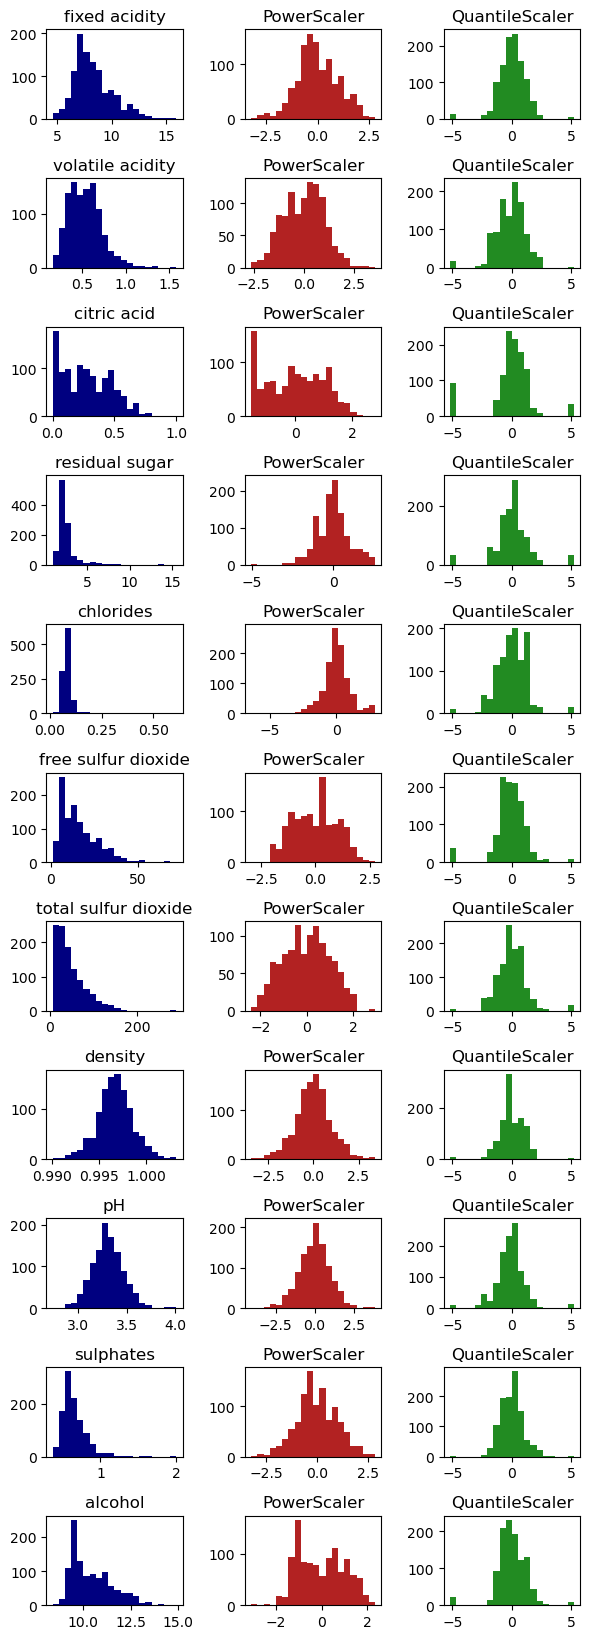

In [140]:
# Zeilen und Spaltenanzahl definieren
n_cols = 3 # Spalten in Originalwerte, PowerTransformation und QuantileTransformation aufteilen
n_rows = 11 # Anzahl der Zeilen 

# Subplots für Histogramme erstellen
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*1.5))

for i in range(n_rows):
    ax[i, 0].hist(X_train[:,i], color='navy', bins=20) # Originalwerte in Blau
    ax[i, 1].hist(X_train_pscl[:,i], color='firebrick', bins=20) # PowerTransformation Werte in Rot
    ax[i, 2].hist(X_train_qscl[:,i], color='forestgreen', bins=20) # QuantileTransformation Werte in Grün

    ax[i, 0].set_title(feature_names[i]) # Feature-Name als Überschrift
    ax[i, 1].set_title('PowerScaler') # PowerScaler als Überschrift
    ax[i, 2].set_title('QuantileScaler') # QuantileScaler als Überschrift

    # ax[i, 1].set_title(f'lambda = {np.round(pscaler.lambdas_[i], 2)}')

plt.tight_layout()
plt.show()

## Add Features

In [142]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
    # Initialize any parameters you need here
        pass

    def fit(self, X, y=None):
    # Fit the transformer to the data (e.g. compute any necessary statistics)
        return self

    def transform(self, X):
# Create the custom features
# Balance refers to the relationship between the four essential elements of wine:
# tannin, acidity, alcohol and sugar.
# Je süßer der Wein desto mehr Säure verträgt er
        acids = X[:,:2].sum(axis=1)
        acids_per_sugar = acids / X[:,3]
        acids_per_alc = acids / X[:, 10]
        alc_per_sugar = X[:, 10] / X[:,3]
        sulf_per_sugar = X[:,6] / X[:, 3]

        new_f = np.column_stack((acids_per_sugar, acids_per_alc, alc_per_sugar, sulf_per_sugar))
        #new_f_inv = 1 / new_f

        X = np.hstack((X, new_f)) #new_f_inv

# um mehr Zucker muss mehr schwefel hinzugefügt werden um Fermentation zu stoppen

# Zucker wird zu Alkohol

        return X

In [144]:
pscaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)


In [146]:
cus_t = CustomFeatureTransformer()
X_new = cus_t.fit_transform(X_train_pscl)

In [148]:
X_newpd = pd.DataFrame(np.hstack((X_new, y_train[:,None])), columns=list(red_wines.columns)[:-1] + ['acid_sugar', 'acid_alc', 'alc_sugar', 'sulf_sugar', 'quality'])


,acid_sugar,acid_alc,alc_sugar,sulf_sugar,quality
acid_sugar,1.00,0.14,-0.42,-0.08,0.08
acid_alc,0.14,1.00,0.01,-0.02,0.04
alc_sugar,-0.42,0.01,1.00,-0.16,-0.11
sulf_sugar,-0.08,-0.02,-0.16,1.00,0.01
quality,0.08,0.04,-0.11,0.01,1.00


<Axes: >

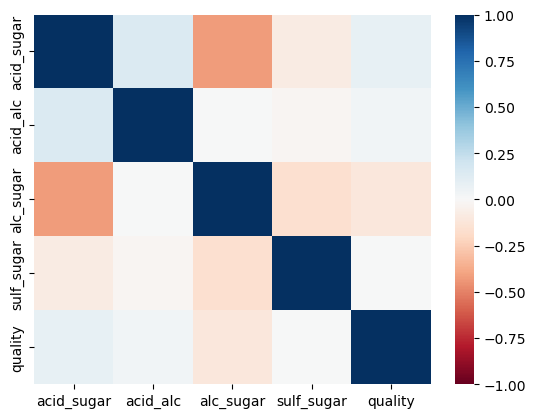

In [150]:
display(X_newpd[['acid_sugar', 'acid_alc', 'alc_sugar', 'sulf_sugar', 'quality']].corr().round(2))
sns.heatmap(X_newpd[['acid_sugar', 'acid_alc', 'alc_sugar', 'sulf_sugar', 'quality']].corr(), vmin=-1, vmax=1, cmap='RdBu')

<Axes: ylabel='Count'>

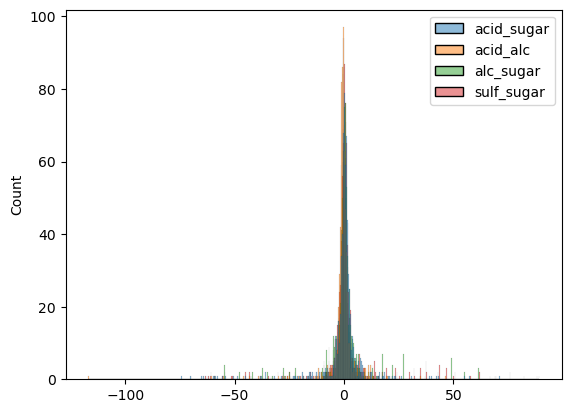

In [152]:
sns.histplot(X_newpd[['acid_sugar', 'acid_alc', 'alc_sugar', 'sulf_sugar']])

## Make Pipeline

In [38]:
preprocessing_pipe = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True, copy=True),
                                CustomFeatureTransformer(),
                                StandardScaler())

In [39]:
X_train_processed = preprocessing_pipe.fit_transform(X_train)

In [40]:
# save transformed X_train
np.savetxt('X_train_processed.csv', X_train_processed, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')



In [41]:
# save pipeline
with open('preprocessing_pipeline.pkl', 'wb') as p_file:
    pickle.dump(preprocessing_pipe, p_file)